In this colab notebook I am exploring, vizualizing and training the train dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Importing libraries:

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# 2. Loading Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/train.csv')
train.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


in the first 5 rows it is seen that there are null values in the meter reading column.

In [ ]:
train.shape

(1749494, 4)

getting the null values

In [ ]:
train.isnull().sum()

,0
building_id,0
timestamp,0
meter_reading,107653
anomaly,0


# 3. Vizualization:

Vizualizing the proportion of null values in the dataset with a pie chart.

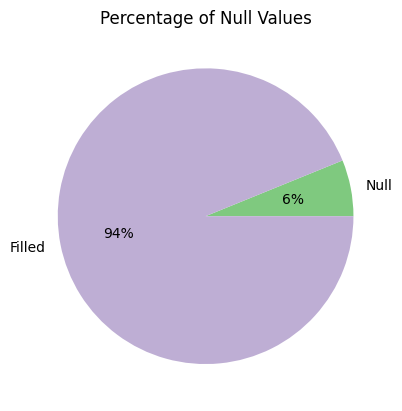

In [ ]:
missing_values = train.isnull().sum().sum()
plt.pie([missing_values, train.shape[0]-missing_values], labels=['Null', 'Filled']\
        , colors=sb.color_palette('Accent'), autopct='%.0f%%')
plt.title('Percentage of Null Values')
plt.show()

total 6% is null values in the dataset and they are in meter_reading column.

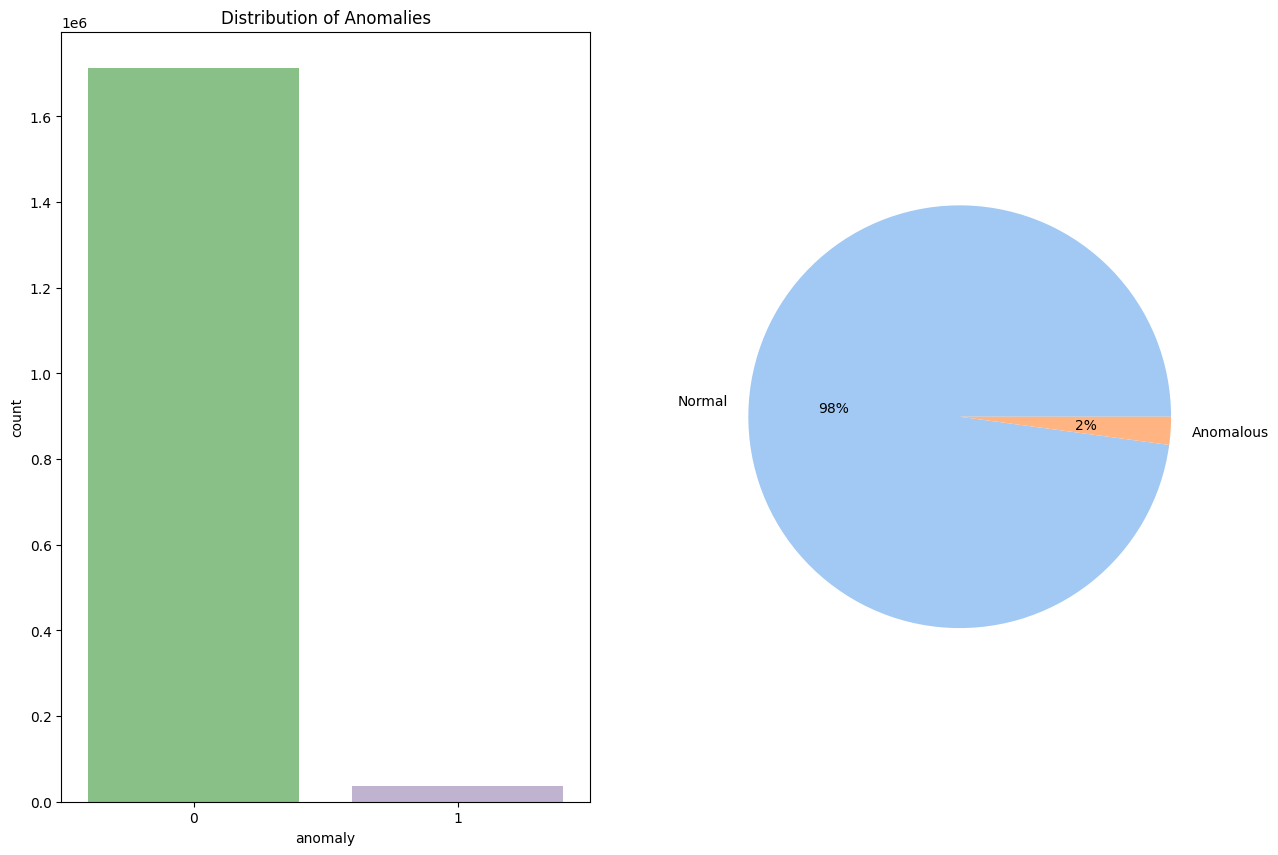

In [ ]:
plt.subplots(figsize=(15,10))
plt.subplot(1,2,1)
sb.countplot(x=train['anomaly'], palette= 'Accent')
plt.title('Distribution of Anomalies')
plt.subplot(1,2,2)
data = train['anomaly'].value_counts()
plt.pie(data, labels=['Normal', 'Anomalous'], colors=sb.color_palette('pastel'), autopct='%.0f%%')

plt.show()

In anomaly detection problems, data imbalance is common because anomalies are rare events that do not occur frequently. If they did occur often, it would suggest a different underlying issue.

In [ ]:
# Converting 'meter_reading' to numeric, handling potential errors
train['meter_reading'] = pd.to_numeric(train['meter_reading'], errors='coerce')

# Calculating the mean meter reading per building
mean_reading = train.groupby('building_id')['meter_reading'].mean()

print(mean_reading)

building_id
1        35.267879
32       98.400360
41       61.162877
55       33.911298
69       30.782749
           ...    
1316     52.996412
1318    158.332296
1319    132.040616
1323    182.157895
1353      7.024886
Name: meter_reading, Length: 200, dtype: float64


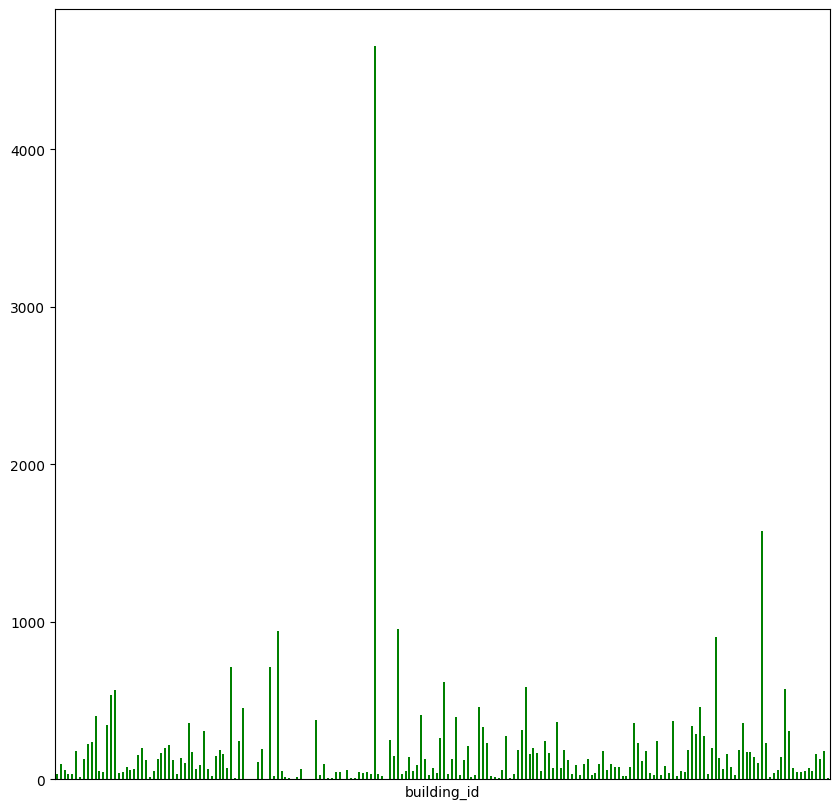

In [ ]:
plt.figure(figsize=(10, 10))
mean_reading.plot(kind='bar', color= 'green')
plt.xticks(ticks=[], labels=[])
plt.show()

Here, with idxmax() I am finding out which building id has the highest mean meter reading.

In [ ]:
mean_reading.idxmax()

801

**Feature Engineering:**


Breaking down timestamp column into date and time

In [ ]:
def split_timestamp(df):
    split_data = df['timestamp'].str.split(' ', n=1, expand=True)
    df['date'] = split_data[0]
    df['hour'] = split_data[1].str[:2].astype(int)
    df = df.drop(columns=['timestamp'])
    return df

train = split_timestamp(train)
train.head()

,building_id,meter_reading,anomaly,date,hour
0,1,NaN,0,2016-01-01,0
1,32,NaN,0,2016-01-01,0
2,41,NaN,0,2016-01-01,0
3,55,NaN,0,2016-01-01,0
4,69,NaN,0,2016-01-01,0


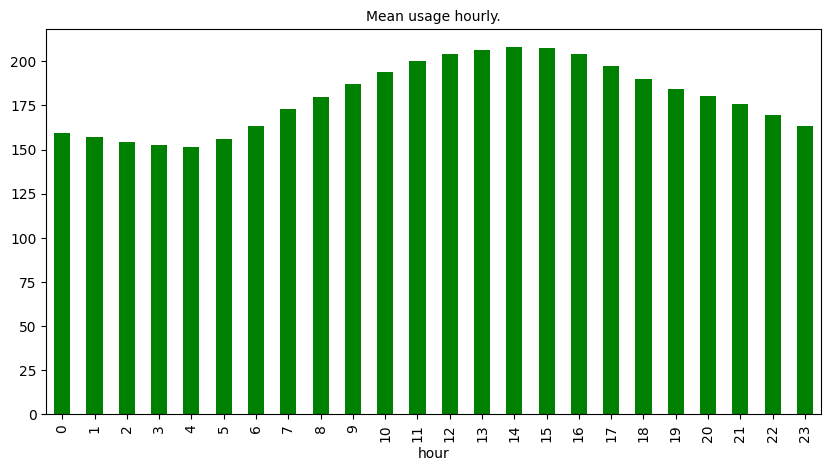

In [ ]:
#'train' already has 'date' and 'hour' columns from a previous call to add_date_time

plt.figure(figsize=(10, 5))
train.groupby('hour')['meter_reading'].mean().plot(kind ='bar', color='green')  # Calculating mean on numeric column
plt.title('Mean usage hourly.', fontsize=10)
plt.show()

In [ ]:
def extract_month_day(df):
    df['month'] = df['date'].str.slice(5, 7).astype(int)
    df['day'] = df['date'].str.slice(-2).astype(int)
    df = df.drop(columns=['date'])
    return df

train = extract_month_day(train)
train.head()

,building_id,meter_reading,anomaly,hour,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


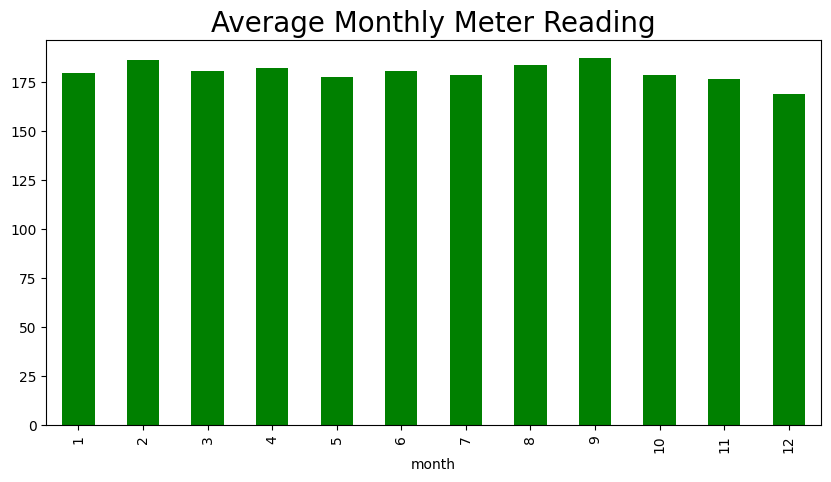

In [ ]:
plt.figure(figsize=(10, 5))
train.groupby('month')['meter_reading'].mean().plot(kind='bar', color='green')
plt.title('Average Monthly Meter Reading', fontsize=20)
plt.show()

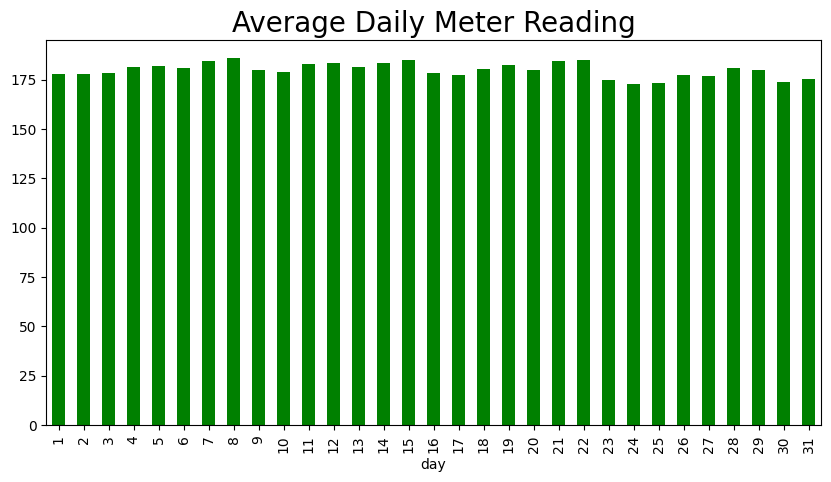

In [ ]:
plt.figure(figsize=(10, 5))
train.groupby('day')['meter_reading'].mean().plot(kind='bar', color='green')
plt.title('Average Daily Meter Reading', fontsize=20)
plt.show()

Getting the 5 rows of the dataset after splitting timestamp

In [ ]:
train.head()

,building_id,meter_reading,anomaly,hour,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


In [ ]:
import datetime as dt
# Function to determine if a date falls on a weekend or a weekday
def is_weekend(year, month, day):
    date = dt.datetime(year, month, day)
    return 1 if date.weekday() > 4 else 0

# Adding a new feature to denote weekends
train['weekend'] = train.apply(lambda row: is_weekend(2016, int(row['month']), int(row['day'])), axis=1)
train.head()

,building_id,meter_reading,anomaly,hour,month,day,weekend
0,1,NaN,0,0,1,1,0
1,32,NaN,0,0,1,1,0
2,41,NaN,0,0,1,1,0
3,55,NaN,0,0,1,1,0
4,69,NaN,0,0,1,1,0


In [ ]:
train['weekend'].value_counts()

,count
weekend,
0,1247563
1,501931


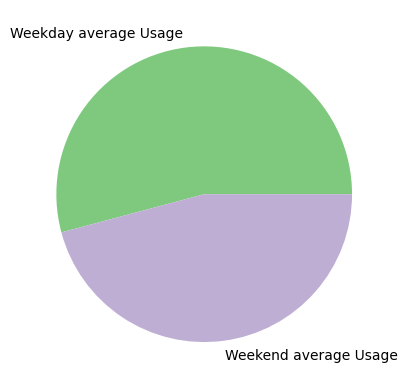

In [ ]:
average_readings = train.groupby('weekend')['meter_reading'].mean()
plt.pie(average_readings, labels=['Weekday average Usage', 'Weekend average Usage'], colors=sb.color_palette('Accent'))
plt.show()

Usage over the weekdays are more than weekend.

# 4. Preprocessing

**Imputing Null values**

In [ ]:
def fill_missing_values(dataset):
    # Calculating the mean meter reading for each building
    average_readings = dataset.groupby('building_id')['meter_reading'].mean()

    # Looping over each building ID and filling missing values with the corresponding mean meter reading
    for building in average_readings.index:
        dataset.loc[dataset['building_id'] == building] = dataset.loc[dataset['building_id'] == building].fillna(average_readings[building])

    return dataset

train = fill_missing_values(train)

By Grouping the data by building_id and calculating the mean of the meter_reading for each building, this mean value will be used to fill in any missing meter_reading values within that specific building.
For each building, identified by its building_id, the code checks if there are any missing values (NaN) in the meter_reading column.If there are missing values, it fills these with the mean meter_reading calculated in the first step for that particular building.
The dataset is then updated in place with the filled values.
Finally, the function returns the updated dataset where all missing meter_reading values have been replaced with the mean values specific to each building.

**Equalizing positive and negative examples:**

Due to imbalance in the data, it's crucial to equalize the positive and negative examples. Without this balance, the model will struggle to generalize the positive examples, which is the primary objective.

In [ ]:
# Separating the negative and positive examples
negative_examples = train[train['anomaly'] == 0]
positive_examples = train[train['anomaly'] == 1]

# Printing the shapes of the negative and positive datasets
print(negative_examples.shape, positive_examples.shape)

# Sampling two subsets of the negative examples
negative_sample1 = negative_examples.sample(n=37296, random_state=10)
negative_sample2 = negative_examples.sample(n=37296, random_state=20)

# Combining the samples and the positive examples
balanced_dataset = pd.concat([negative_sample1, positive_examples, negative_sample2, positive_examples], axis=0)

# Print the shape of the balanced dataset
print(balanced_dataset.shape)

(1712198, 7) (37296, 7)
(149184, 7)


Although this method prevents my model from seeing the entire dataset, it helps improve the model's ability to generalize to both positive and negative examples.

In [ ]:
feature_set = balanced_dataset.drop(['building_id', 'anomaly'], axis=1)
target_variable = balanced_dataset['anomaly']

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(feature_set, target_variable, test_size = 0.01, random_state=10)
print(X_train.shape, X_val.shape)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

(147692, 5) (1492, 5)


feature_set: This variable contains all the features (independent variables) used for training the model, excluding building_id and anomaly.
target_variable: This variable contains the target variable (dependent variable) that the model aims to predict, which is anomaly.

# 5. Model

I am using Logistic Regression, XGB classifier, decesion tree, HistGradientBoosting, CatBoost and LightGBM to see which can give best accuracy for this dataset.

In [ ]:
from sklearn.metrics import accuracy_score
# Defining the models to be evaluated
model_list1 = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(), lgb.LGBMClassifier(n_estimators=100)]

# Iterating over each model to train and evaluate
for model in model_list1:
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Printing model details and evaluation metrics
    print(f'Model: {model}')
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    print('Training:', accuracy_score(Y_train, train_predictions))
    print('Validation:', accuracy_score(Y_val, val_predictions))
    print()

Model: LogisticRegression()
Training: 0.5497386452888443
Validation: 0.5288203753351206

Model: DecisionTreeClassifier()
Training: 0.9996953118652331
Validation: 0.9638069705093834

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training: 0.8838528830268396
Validation: 0.8900804289

For binary prediction the score of each model is not very high. Therefore I am using roc_auc_scores.

**Using roc_auc:**

In [ ]:
from sklearn.metrics import roc_auc_score
# Defining the models to be evaluated
model_list2 = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(), lgb.LGBMClassifier(n_estimators=100)]

# Iterating over each model to train and evaluate
for model in model_list2:
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Printing model details and evaluation metrics
    print(f'Model: {model}')
    train_predictions = model.predict_proba(X_train)[:, 1]
    val_predictions = model.predict_proba(X_val)[:, 1]
    print('Training:', roc_auc_score(Y_train, train_predictions))
    print('Validation:', roc_auc_score(Y_val, val_predictions))
    print()

Model: LogisticRegression()
Training: 0.5695351545651138
Validation: 0.5605979721289052

Model: DecisionTreeClassifier()
Training: 0.9999996602014816
Validation: 0.963768115942029

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training: 0.951692506043518
Validation: 0.948913178286

For probability prediction the accuracy of the logistic regression model is quite low, whereas the XGBClassifier and others are performing excellently, achieving a 94% validation accuracy without any signs of overfitting.
Evaluating scores using binary predictions and probability predictions results in different scores for the same set of predictions.

Model: LogisticRegression()
Model: DecisionTreeClassifier()
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Model: HistGradientBoostingClassifier()
Model: <catboost.core.CatBoostClassifier object at 0x7f47041ca5f0>
[LightGBM] [Info] Number of positive: 73859, number of negative: 738

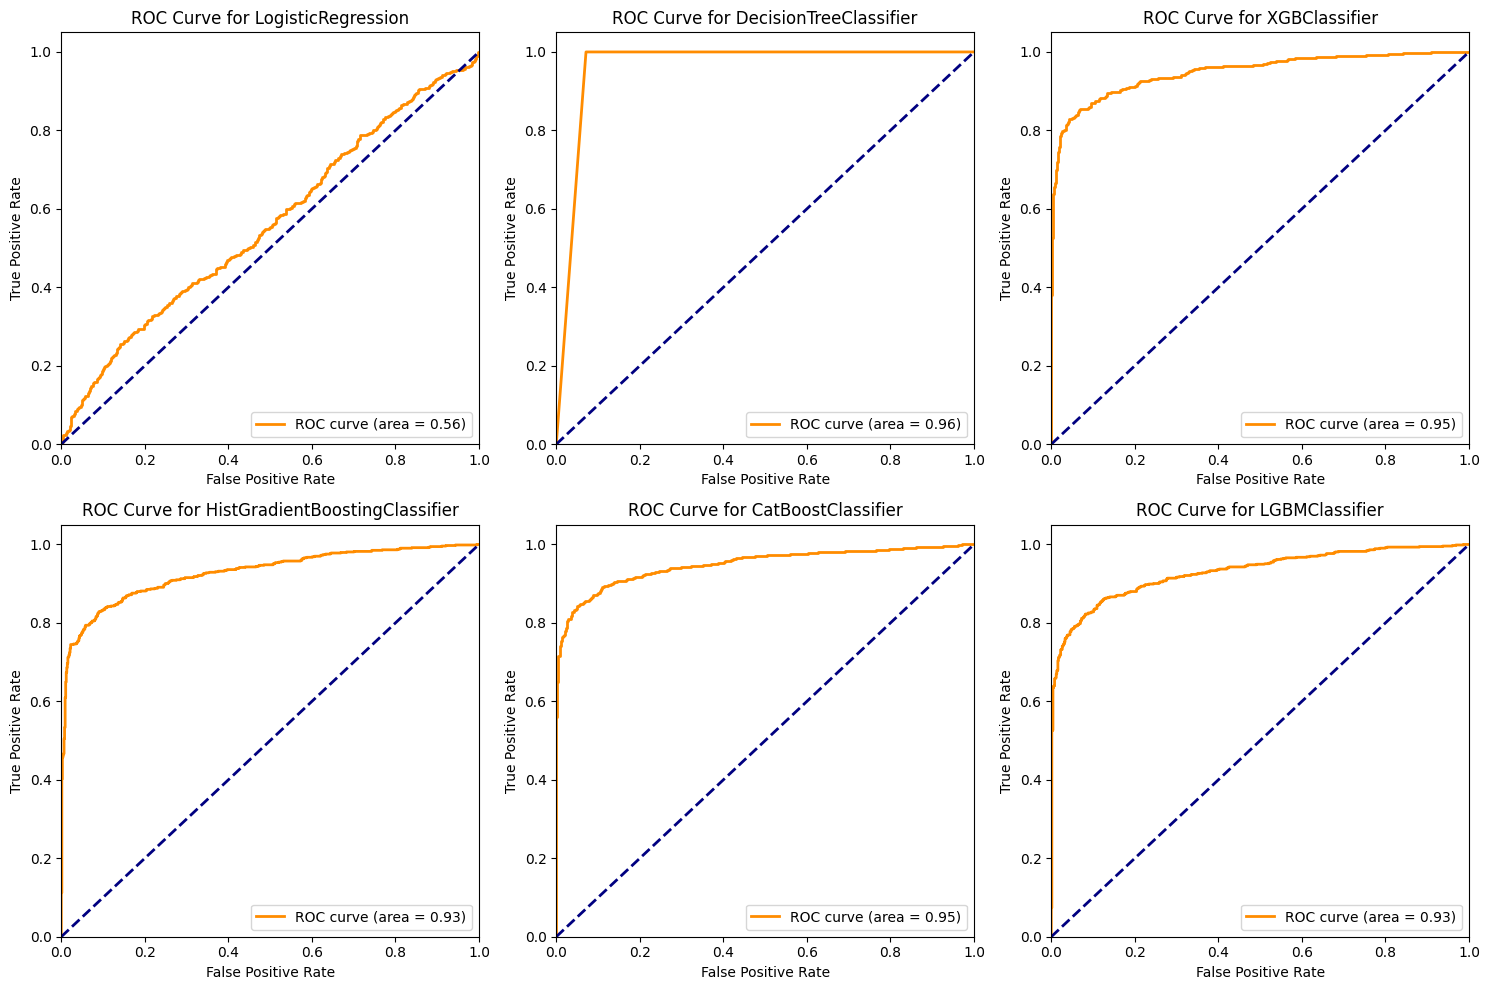

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Defining the models to be evaluated
model_list2 = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(), HistGradientBoostingClassifier(),
                CatBoostClassifier(verbose=0), lgb.LGBMClassifier(n_estimators=100)]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Iterating over each model to train and evaluate
for i, model in enumerate(model_list2):
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Printing model details and evaluation metrics
    print(f'Model: {model}')
    train_predictions = model.predict_proba(X_train)[:, 1]
    val_predictions = model.predict_proba(X_val)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_val, val_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve in the corresponding subplot
    axes[i].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve for {model.__class__.__name__}')
    axes[i].legend(loc="lower right")

plt.tight_layout()
plt.show()

omitting logistic regression, decision tree and catboost.

In [ ]:
from sklearn.metrics import roc_auc_score
# Defining the models to be evaluated
model_list3 = [ XGBClassifier(), HistGradientBoostingClassifier(), lgb.LGBMClassifier(n_estimators=100)]

# Iterating over each model to train and evaluate
for model in model_list3:
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Printing model details and evaluation metrics
    print(f'Model: {model}')
    train_predictions = model.predict_proba(X_train)[:, 1]
    val_predictions = model.predict_proba(X_val)[:, 1]
    print('Training:', roc_auc_score(Y_train, train_predictions))
    print('Validation:', roc_auc_score(Y_val, val_predictions))
    print()

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training: 0.951692506043518
Validation: 0.9489131782862136

Model: HistGradientBoostingClassifier()
Training: 0.9238897811466797
Validation: 0.9260182943378863

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[Li

In [ ]:
from sklearn.metrics import roc_auc_score
# Defining the models to be evaluated
model_list4 = [ XGBClassifier(), HistGradientBoostingClassifier(), lgb.LGBMClassifier(n_estimators=100), CatBoostClassifier(verbose=0)]

# Iterating over each model to train and evaluate
for model in model_list4:
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Printing model details and evaluation metrics
    print(f'Model: {model}')
    train_predictions = model.predict_proba(X_train)[:, 1]
    val_predictions = model.predict_proba(X_val)[:, 1]
    print('Training:', roc_auc_score(Y_train, train_predictions))
    print('Validation:', roc_auc_score(Y_val, val_predictions))
    print()

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training: 0.951692506043518
Validation: 0.9489131782862136

Model: HistGradientBoostingClassifier()
Training: 0.9241394635576071
Validation: 0.9268055727810163

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[Li

**Model enesembling:**

Ensemble model_list2:

In [ ]:
# Ensemble model_list2

# Creating an empty list to store predictions from individual models
val_predictions = []

# Iterating over each model in model_list2
for model in model_list2:
  # Fitting the model on the training data
  model.fit(X_train, Y_train)

  # Getting predictions from the model
  predictions = model.predict_proba(X_val)[:, 1]

  # Appending the predictions to the list
  val_predictions.append(predictions)

# Calculating the average predictions across all models
avg_predictions = np.mean(val_predictions, axis=0)

# Calculating and printing the ROC AUC score for the ensemble
print('Ensemble Model:')
print('Training ROC AUC:', roc_auc_score(Y_train, train_predictions))
print('Validation ROC AUC:', roc_auc_score(Y_val, avg_predictions))

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 147692, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500088 -> initscore=0.000352
[LightGBM] [Info] Start training from score 0.000352
Ensemble Model:
Training ROC AUC: 0.9494756302523826
Validation ROC AUC: 0.9873801781981391


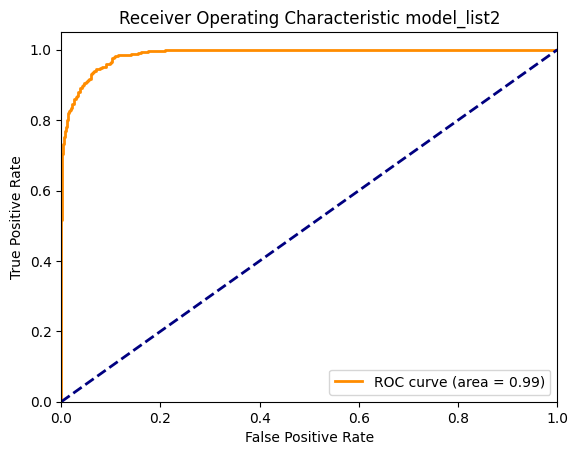

In [ ]:
# Plotting ROC curve for the ensemble model_list2
fpr, tpr, thresholds = metrics.roc_curve(Y_val, avg_predictions) # Changed val_predictions to avg_predictions
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic model_list2')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Ensemble model_list3

# Creating an empty list to store predictions from individual models
val_predictions3 = []

# Iterating over each model in model_list3
for model in model_list3:
  # Fitting the model on the training data
  model.fit(X_train, Y_train)

  # Getting predictions from the model
  predictions = model.predict_proba(X_val)[:, 1]

  # Appending the predictions to the list
  val_predictions3.append(predictions)

# Calculating the average predictions across all models
avg_predictions = np.mean(val_predictions3, axis=0)

# Calculating and printing the ROC AUC score for the ensemble
print('Ensemble Model:')
print('Training ROC AUC:', roc_auc_score(Y_train, train_predictions))
print('Validation ROC AUC:', roc_auc_score(Y_val, avg_predictions))

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 147692, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500088 -> initscore=0.000352
[LightGBM] [Info] Start training from score 0.000352
Ensemble Model:
Training ROC AUC: 0.9494756302523826
Validation ROC AUC: 0.9423165758061065


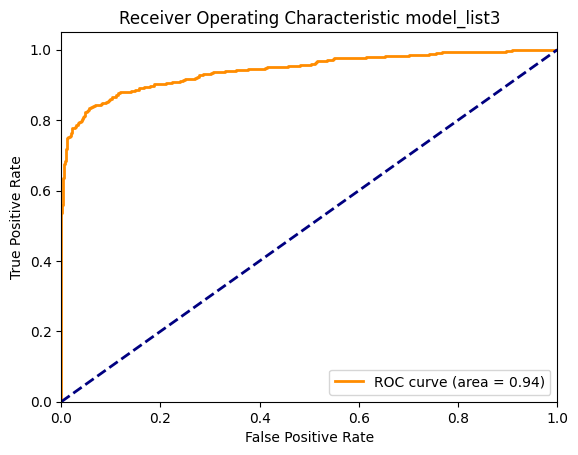

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np # Added import for np.mean

# Plotting ROC curve for the ensemble model
# Calculate the average predictions across all models
avg_predictions = np.mean(val_predictions3, axis=0)

fpr, tpr, thresholds = metrics.roc_curve(Y_val, avg_predictions) # Changed val_predictions3 to avg_predictions
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic model_list3')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Ensemble model_list4

# Creating an empty list to store predictions from individual models
val_predictions4 = []

# Iterating over each model in model_list4
for model in model_list4:
  # Fitting the model on the training data
  model.fit(X_train, Y_train)

  # Getting predictions from the model
  predictions = model.predict_proba(X_val)[:, 1]

  # Appending the predictions to the list
  val_predictions4.append(predictions)

# Calculating the average predictions across all models
avg_predictions = np.mean(val_predictions4, axis=0)

# Calculating and printing the ROC AUC score for the ensemble
print('Ensemble Model:')
print('Training ROC AUC:', roc_auc_score(Y_train, train_predictions))
print('Validation ROC AUC:', roc_auc_score(Y_val, avg_predictions))

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 147692, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500088 -> initscore=0.000352
[LightGBM] [Info] Start training from score 0.000352
Ensemble Model:
Training ROC AUC: 0.9494756302523826
Validation ROC AUC: 0.9462835244910103


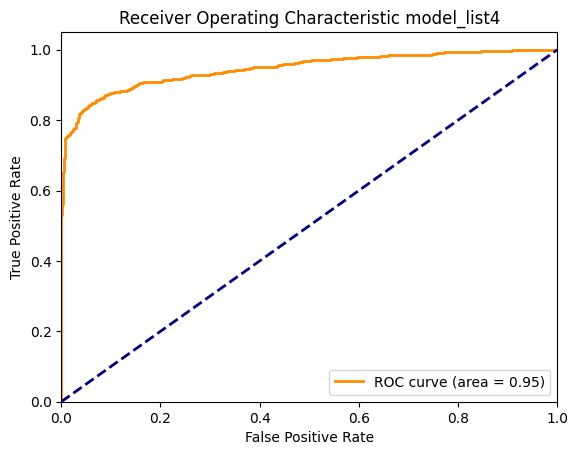

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np # Added import for np.mean

# Plotting ROC curve for the ensemble model
# Calculate the average predictions across all models
avg_predictions = np.mean(val_predictions4, axis=0)

fpr, tpr, thresholds = metrics.roc_curve(Y_val, avg_predictions) # Changed val_predictions4 to avg_predictions
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic model_list4')
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 73859, number of negative: 73833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 147692, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500088 -> initscore=0.000352
[LightGBM] [Info] Start training from score 0.000352


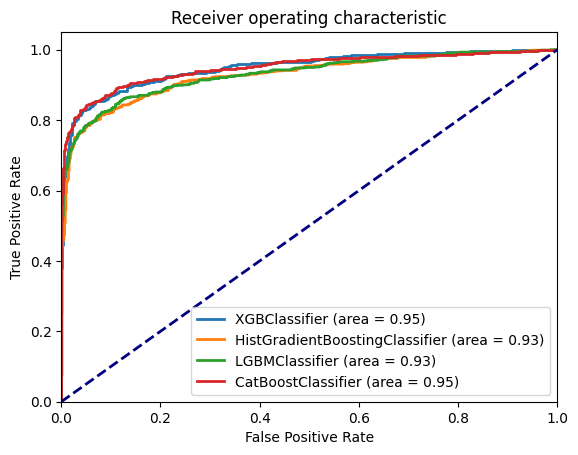

In [ ]:
from sklearn.metrics import roc_curve, auc

# Defining the models to be evaluated
model_list3 = [XGBClassifier(), HistGradientBoostingClassifier(), lgb.LGBMClassifier(n_estimators=100), CatBoostClassifier(verbose=0)]

# Plot ROC curves for each model
plt.figure()
for model in model_list3:
    # Fit the model on the training data
    model.fit(X_train, Y_train)

    # Get the predicted probabilities for the validation set
    y_pred_proba = model.predict_proba(X_val)[:,1]

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(Y_val, y_pred_proba)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Test dataset:**

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/test.csv', index_col=0)
test = split_timestamp(test)
test = extract_month_day(test)
test['weekend'] = test.apply(lambda x:\
                               is_weekend(int(2016),int(x['month']),int(x['day'])),axis=1)
test.head()

,building_id,meter_reading,hour,month,day,weekend
row_id,,,,,,
0,18,NaN,0,1,1,0
1,19,NaN,0,1,1,0
2,26,NaN,0,1,1,0
3,38,NaN,0,1,1,0
4,39,NaN,0,1,1,0


In [ ]:
test.shape

(1800567, 6)

In [ ]:
test.isnull().sum()

,0
building_id,0
meter_reading,94864
hour,0
month,0
day,0
weekend,0


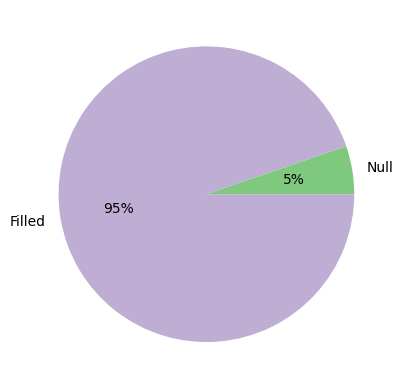

In [ ]:
k = test.isnull().sum().sum()
plt.pie([k, test.shape[0]-k], labels=['Null', 'Filled']\
        , colors=sb.color_palette('Accent'), autopct='%.0f%%')
plt.show()

Approximately 5% of the meter_reading entries in the test data are null, which is comparable to the train data, where around 6% of the meter_reading entries are null.

**Imputing nulls:**

In [ ]:
test = fill_missing_values(test)
test.isnull().sum().sum()

0

**6. Evaluation**

In [ ]:

# Creating an empty list to store predictions from individual models
test_predictions = []

# Iterating over each model in model_list2
for model in model_list2:
  # Getting predictions from the model
  # Ensure the test data has the same number of features as the model was trained on
  predictions = model.predict_proba(test.iloc[:, :5])[:, 1] # Select the first 5 columns of the test data

  # Appending the predictions to the list
  test_predictions.append(predictions)

# Calculating the average predictions across all models
avg_predictions = np.mean(test_predictions, axis=0)

# Create a submission DataFrame
submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/sample_submission.csv')
submission_df = pd.DataFrame({'row_id': range(len(avg_predictions)), 'anomaly': avg_predictions})

# Save the DataFrame to a CSV file named 'submission_ensemble2.csv'

submission_df.to_csv('submission_df.csv', index=False)
print(submission_df.head())

   row_id   anomaly
0       0  0.336075
1       1  0.337845
2       2  0.337166
3       3  0.336083
4       4  0.336108


In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy-anomaly-detection/sample_submission.csv')
ss['anomaly'] = predictions
ss.to_csv('Submission.csv', index=False)
ss.head()

,row_id,anomaly
0,0,0.500955
1,1,0.500955
2,2,0.500955
3,3,0.500955
4,4,0.500955
